# SAD Project 2 with TF
---
**Younginn Park**

## Data Preparation

In [1]:
# Based on keras CVAE tutorial notebook
# https://www.tensorflow.org/tutorials/generative/cvae

from glob import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time

import keras
from keras import layers

import pandas as pd
import os

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Seed for reproducibility
seed = 42
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)

In [3]:

train_dir = '/kaggle/input/fundus-pytorch/train'

img_size = (224, 224) # change image size
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_data = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

Found 8621 images belonging to 2 classes.


In [5]:
# Check the class indices
class_indices = train_data.class_indices
print("Class indices:", class_indices)

Class indices: {'0': 0, '1': 1}


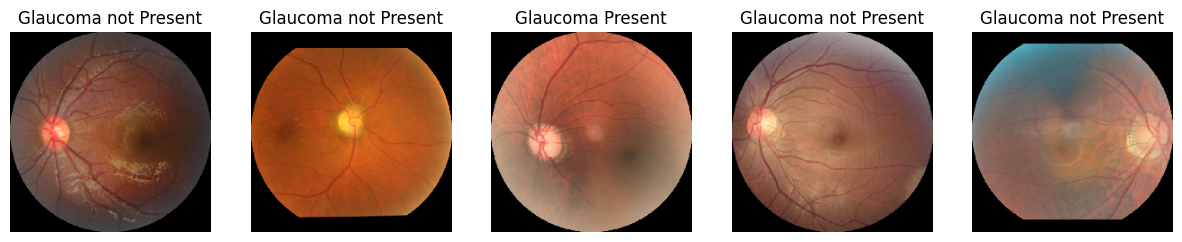

In [6]:
# Check the shape of the images and get corresponding labels
sample_images, sample_labels = train_data.next()

# Visualize the first 5 images in one row with labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

label_map = {
    0: "Glaucoma not Present", 
    1: "Glaucoma Present",
}

for i in range(5):
    img = array_to_img(sample_images[i])
    label = sample_labels[i].argmax()  # For one-hot encoding, get the index of the class
    axes[i].imshow(img)
    axes[i].set_title(label_map[label])
    axes[i].axis('off')

plt.show()

In [7]:
# Check the shape of one image
sample_image, _ = train_data.next()
image_shape = sample_image[0].shape

print("Shape of one image:", image_shape)

Shape of one image: (224, 224, 3)


In [8]:
# Count the number of samples in each class for the training set
num_class_0_train = sum(train_data.classes == 0)
num_class_1_train = sum(train_data.classes == 1)

# Calculate the proportion of each class
proportion_class_0_train = num_class_0_train / len(train_data.classes)
proportion_class_1_train = num_class_1_train / len(train_data.classes)

# Print the summary
print(f"Proportion of Class 0 ({label_map[0]}) in training set: {proportion_class_0_train:.2%}")
print(f"Proportion of Class 1 ({label_map[1]}) in training set: {proportion_class_1_train:.2%}")


Proportion of Class 0 (Glaucoma not Present) in training set: 61.40%
Proportion of Class 1 (Glaucoma Present) in training set: 38.60%


### Short summary

The fundus SMDG 19 dataset is a collection and standardization of 19 public datasets, comprised of full-fundus glaucoma images. Full fundus images are standardized by cropping the background, centering the fundus image, padding missing information, and resizing to 512x512 pixels.

In this project, the images were resized to 224x224 and normalized while retaining the RGB color channels. 8621 images were used as a training set, 61.40% being of class 0, where Glaucoma is not present and 38.60% of class 1 - Glaucoma present. This project utilizes Tensorflow and Keras for VAE implementation.

[Link to Dataset on GitHub](https://github.com/TheBeastCoding/standardized-multichannel-dataset-glaucoma) \
[Link to Dataset on Kaggle](https://www.kaggle.com/datasets/sabari50312/fundus-pytorch/data)

## Model Definition and Test Run

In [9]:
class Sampling(layers.Layer):
    """Reparametrization trick - uses (z_mean, z_log_var) to sample z"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [10]:
# Simple VAE
def create_encoder(latent_dim, verbose=False):

    encoder_inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    if verbose:
        encoder.summary()
        plot_model(encoder, to_file="model_e.png", show_shapes=True)
    
    return encoder

def create_decoder(latent_dim, verbose=False):
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(28 * 28 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((28, 28, 64))(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    
    if verbose:
        decoder.summary()
        plot_model(decoder, to_file="model_d.png", show_shapes=True)
        
    return decoder

In [11]:
# Hierarchical VAE
# n/a
def create_encoder_h(latent_dims, verbose=False):
    # Define dimensions for latent layers
    latent_dim_layer1 = latent_dims[0]
    latent_dim_layer2 = latent_dims[1]
    
    # Encoder for the first latent layer
    encoder_inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean_layer1 = layers.Dense(latent_dim_layer1, name="z_mean_layer1")(x)
    z_log_var_layer1 = layers.Dense(latent_dim_layer1, name="z_log_var_layer1")(x)
    z_layer1 = Sampling()([z_mean_layer1, z_log_var_layer1])

    # Encoder for the second latent layer
    z_layer1_repeat = layers.RepeatVector(latent_dim_layer2)(z_layer1)
    x = layers.concatenate([z_layer1_repeat, z_layer1], axis=-1)  # Concatenate both latent layers
    x = layers.Dense(16, activation="relu")(x)
    z_mean_layer2 = layers.Dense(latent_dim_layer2, name="z_mean_layer2")(x)
    z_log_var_layer2 = layers.Dense(latent_dim_layer2, name="z_log_var_layer2")(x)
    z_layer2 = Sampling()([z_mean_layer2, z_log_var_layer2])

    encoder = keras.Model(
        encoder_inputs, 
        [z_mean_layer1, z_log_var_layer1, z_layer1, z_mean_layer2, z_log_var_layer2, z_layer2], 
        name="encoder"
    )
    
    if verbose:
        encoder.summary()
        plot_model(encoder, to_file="model_encoder.png", show_shapes=True)
    
    return encoder

def create_decoder_h(latent_dims, verbose=False):
    # Define dimensions for latent layers
    latent_dim_layer1 = latent_dims[0]
    latent_dim_layer2 = latent_dims[1]
    
    # Decoder for the second latent layer
    latent_inputs_layer2 = keras.Input(shape=(latent_dim_layer2,))
    x = layers.Dense(8, activation="relu")(latent_inputs_layer2)
    x = layers.RepeatVector(latent_dim_layer1)(x)
    x = layers.concatenate([z_layer1, x], axis=-1)  # Assuming z_layer1 is defined globally
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Reshape((28, 28, 64))(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

    decoder = keras.Model([latent_inputs_layer2, z_layer1], decoder_outputs, name="decoder")
    
    if verbose:
        decoder.summary()
        plot_model(decoder, to_file="model_decoder.png", show_shapes=True)
    
    return decoder


In [12]:
# AlexNet-like VAE
# n/a
def create_encoder_alex(latent_dim, verbose=False):
    """Encoder with AlexNet-like architecture"""
    encoder_inputs = keras.Input(shape=(224, 224, 3))

    # Convolutional Block 1
    x = layers.Conv2D(96, (11, 11), strides=(4, 4), activation="relu", padding="valid")(encoder_inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Convolutional Block 2
    x = layers.Conv2D(256, (5, 5), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Convolutional Block 3
    x = layers.Conv2D(384, (3, 3), activation="relu", padding="same")(x)

    # Convolutional Block 4
    x = layers.Conv2D(384, (3, 3), activation="relu", padding="same")(x)

    # Convolutional Block 5
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dense(4096, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    if verbose:
        encoder.summary()
        plot_model(encoder, to_file="model_e.png", show_shapes=True)
        
    return encoder

def create_decoder_alex(latent_dim, verbose=False):
    decoder_inputs = keras.Input(shape=(latent_dim,))

    # Dense layers
    x = layers.Dense(4096, activation="relu")(decoder_inputs)
    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Reshape((1, 1, 4096))(x)

    # Upsampling and Transposed Convolutional Blocks
    x = layers.UpSampling2D((28, 28))(x)  # Adjust the upsampling factor
    x = layers.Conv2DTranspose(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, (3, 3), activation="relu", padding="same")(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(384, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(384, (3, 3), activation="relu", padding="same")(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(256, (5, 5), activation="relu", padding="same")(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(96, (11, 11), activation="relu", padding="same")(x)

    # Output layer
    decoder_outputs = layers.Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)

    decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

    if verbose:
        decoder.summary()
        keras.utils.plot_model(decoder, to_file="model_d.png", show_shapes=True)

    return decoder


In [13]:
# for VAE
latent_dim = 128

# for HVAE
# latent_dim = [128, 128]

encoder = create_encoder(latent_dim, verbose=True)
decoder = create_decoder(latent_dim, verbose=True)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 56, 56, 32)           4640      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 28, 28, 64)           18496     ['conv2d_1[0][0]']            
                                                                                            

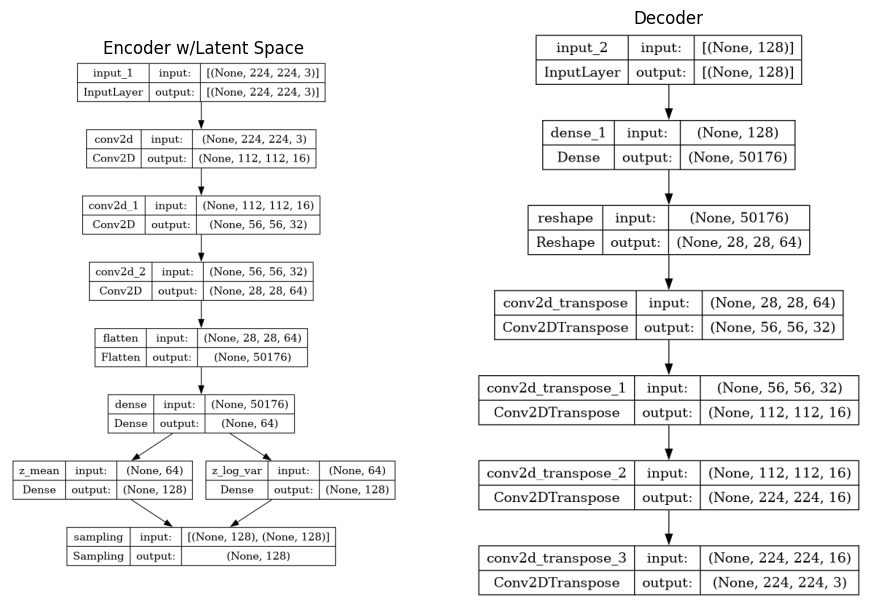

In [14]:
# Visualization of the model architectures
# Define image file paths
file_path_e = "/kaggle/working/model_e.png"
file_path_d = "/kaggle/working/model_d.png"

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# figure size in inches, optional
rcParams['figure.figsize'] = 11 ,10

# read images
img_A = mpimg.imread(file_path_e)
img_B = mpimg.imread(file_path_d)


# display images
fig, ax = plt.subplots(1,2)
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Encoder w/Latent Space')
ax[1].set_title('Decoder')

ax[0].imshow(img_A)
ax[1].imshow(img_B)

plt.show()

In [15]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction),
                              axis=(1, 2, 3))
            ) # mse
            
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction),
#                     axis=(1, 2),
#                 )
#             ) # bce

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss * self.beta
        
        # Backward pass
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [16]:
# Hierarchical with 2 latent layers
# n/a
class HCVAE(VAE):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(encoder, decoder, beta, **kwargs)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # Forward pass
            latent_vars = self.encoder(data)
            reconstructions = self.decoder(latent_vars)

            # mse
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstructions), axis=(1, 2, 3)))

            # KL divergence for all latent layers
            kl_losses = []

            for i in range(0, len(latent_vars), 3):  # Assuming latent_vars contains z_mean, z_log_var, and z for each layer
                z_mean, z_log_var, z = latent_vars[i], latent_vars[i + 1], latent_vars[i + 2]

                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
                kl_losses.append(kl_loss)

            # Total KL divergence
            kl_loss = tf.reduce_sum(kl_losses)

            # Total loss
            total_loss = reconstruction_loss + self.beta * kl_loss

        # Backward pass
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

epochs = 10

vae = VAE(encoder, decoder, beta=0.3)
vae.compile(optimizer=optimizer)
history = vae.fit(train_data, epochs=epochs)

Epoch 1/10
270/270 [==============================] - 168s 600ms/step - loss: 7094.9404 - reconstruction_loss: 3429.9739 - kl_loss: 195.9879
Epoch 2/10
270/270 [==============================] - 87s 324ms/step - loss: 982.6732 - reconstruction_loss: 815.1407 - kl_loss: 200.4739
Epoch 3/10
270/270 [==============================] - 88s 326ms/step - loss: 748.0906 - reconstruction_loss: 671.0410 - kl_loss: 187.5900
Epoch 4/10
270/270 [==============================] - 87s 323ms/step - loss: 696.8077 - reconstruction_loss: 630.6825 - kl_loss: 182.3819
Epoch 5/10
270/270 [==============================] - 88s 325ms/step - loss: 663.5529 - reconstruction_loss: 601.6488 - kl_loss: 174.1999
Epoch 6/10
270/270 [==============================] - 92s 340ms/step - loss: 629.2385 - reconstruction_loss: 575.9868 - kl_loss: 171.3327
Epoch 7/10
270/270 [==============================] - 89s 329ms/step - loss: 616.6475 - reconstruction_loss: 563.6610 - kl_loss: 165.8207
Epoch 8/10
270/270 [===========

In [18]:
history.history.keys()

dict_keys(['loss', 'reconstruction_loss', 'kl_loss'])

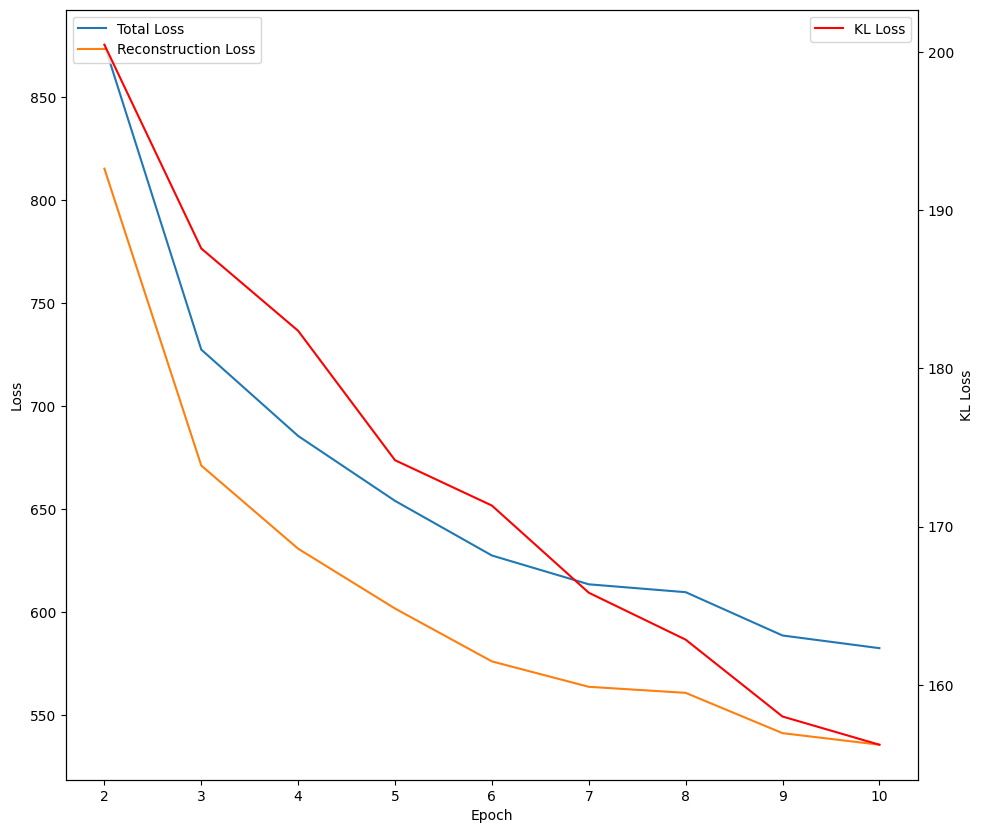

In [19]:
# Without the first epoch
xs = np.arange(2, epochs+1)
plt.plot(xs, history.history['loss'][1:], label='Total Loss')
plt.plot(xs, history.history['reconstruction_loss'][1:], label='Reconstruction Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

ax2 = plt.gca().twinx()
ax2.plot(xs, history.history['kl_loss'][1:], 'r', label='KL Loss')
ax2.set_ylabel('KL Loss')
ax2.legend(loc='upper right')

plt.show()

### Short summary

3 VAE architectures were taken into consideration:
- Simple VAE - having simple Encoder and Decoder with 3 convolutional layers (dims=16,32,64) and 1 latent layer
- Hierarchical VAE - with the Encoder and Decoder like in the Simple VAE, but 2 latent layers
- AlexNet-like VAE - with the Encoder and Decoder architecture that mimics the one used in 2012 AlexNet with 1 latent layer ([Wikipedia](https://en.wikipedia.org/wiki/AlexNet))

Ultimately, the Simple VAE architecture was chosen for the best performance.

## Parameter optimizations
### Learning rate optimization

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Learning rate optimization
learning_rates = [0.001, 0.005, 0.01, 0.05]
beta = 0.
latent_dim = 128
trials_per_setting = 1

epochs = 10

In [23]:
print(f"Learning rate optimization with Beta={beta} and Latent_dim={latent_dim}")

reconstruction_losses_per_lr = []

for lr in learning_rates:
    reconstruction_losses = []
    print(f"Conducting trials for LR={lr}")
    for trial in range(trials_per_setting):
        print(f"Trial {trial}/trials_per_setting")
        encoder = create_encoder(latent_dim)
        decoder = create_decoder(latent_dim)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        vae = VAE(encoder, decoder, beta=beta)
        vae.compile(optimizer=optimizer)
        history = vae.fit(train_data, epochs=epochs)#, verbose=0)
        
        reconstruction_losses.append(history.history['reconstruction_loss'][1:])  # Start from the 2nd epoch
        
        
        # not sure why
        # but w/o cleaning loss=nan
        # in subsequent runs
        del(encoder)
        del(decoder)
        del(vae)
        del(history)
        
    reconstruction_losses_per_lr.append((lr, np.mean(reconstruction_losses, axis=0)))


Learning rate optimization with Beta=0.0 and Latent_dim=128
Conducting trials for LR=0.001
Epoch 1/10
270/270 [==============================] - 89s 316ms/step - loss: 5223.8002 - reconstruction_loss: 2407.8984 - kl_loss: 6448.8589
Epoch 2/10
270/270 [==============================] - 85s 314ms/step - loss: 598.4569 - reconstruction_loss: 555.2805 - kl_loss: 781.3184
Epoch 3/10
270/270 [==============================] - 86s 317ms/step - loss: 444.5815 - reconstruction_loss: 423.0204 - kl_loss: 754.8672
Epoch 4/10
270/270 [==============================] - 85s 314ms/step - loss: 378.5124 - reconstruction_loss: 373.9257 - kl_loss: 713.3143
Epoch 5/10
270/270 [==============================] - 88s 325ms/step - loss: 343.9475 - reconstruction_loss: 335.9958 - kl_loss: 702.2047
Epoch 6/10
270/270 [==============================] - 84s 311ms/step - loss: 309.8651 - reconstruction_loss: 307.7720 - kl_loss: 705.2881
Epoch 7/10
270/270 [==============================] - 85s 314ms/step - loss: 2

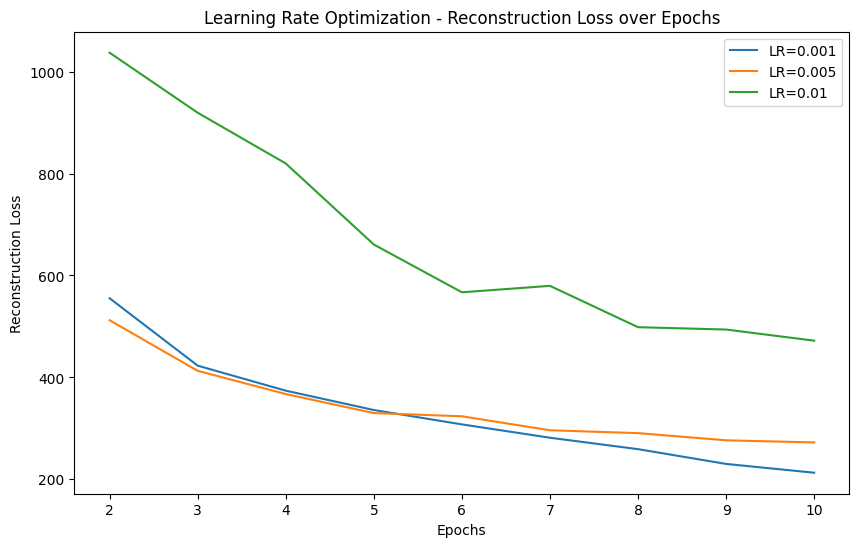

In [28]:
# Visualize Learning rate optimization results
plt.figure(figsize=(10, 6))

i=0
for lr, reconstruction_losses in reconstruction_losses_per_lr:
    
    if i==3:
        # w/o lr=0.05
        break
    i+=1
    
    plt.plot(np.arange(2, epochs+1), reconstruction_losses, label=f'LR={lr}')

plt.title('Learning Rate Optimization - Reconstruction Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()

In [30]:
# Collect final reconstruction losses for each learning rate
final_losses_per_lr = []

for lr, reconstruction_losses in reconstruction_losses_per_lr:
    final_loss = reconstruction_losses[-1]
    final_losses_per_lr.append((lr, final_loss))

best_lr = min(final_losses_per_lr, key=lambda x: x[1])[0]

print(f"Best learning rate: {best_lr}")

Best learning rate: 0.001


### Beta and Latent space dimension optimization

In [73]:
lr = 0.001 # best_lr
beta_values = [0.0, 0.5, 1.0, 2.0]
latent_dim_values = [64, 128, 256]
trials_per_setting = 1
epochs = 10

results_total_loss = np.zeros((len(beta_values), len(latent_dim_values), trials_per_setting, epochs - 1))
results_reconstruction_loss = np.zeros((len(beta_values), len(latent_dim_values), trials_per_setting, epochs - 1))
results_kl_loss = np.zeros((len(beta_values), len(latent_dim_values), trials_per_setting, epochs - 1))

In [74]:
for i, beta in enumerate(beta_values):
    for j, latent_dim in enumerate(latent_dim_values):
        reconstruction_losses_per_trial = []
        kl_losses_per_trial = []
        total_losses_per_trial = []
        
        print(f"Conducting trials for Beta={beta} and Latent_dim={latent_dim}")
        for trial in range(trials_per_setting):
            print(f"Trial {trial+1}/{trials_per_setting}")
            encoder = create_encoder(latent_dim)
            decoder = create_decoder(latent_dim)
            vae = VAE(encoder, decoder, beta=beta)
            vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
            history = vae.fit(train_data, epochs=epochs)#, verbose=0)
            
            # Start from epoch 2
            reconstruction_losses_per_trial.append(history.history['reconstruction_loss'][1:])
            kl_losses_per_trial.append(history.history['kl_loss'][1:])
            total_losses_per_trial.append(history.history['loss'][1:])
            
            # Cleanup to avoid memory issues
            del encoder
            del decoder
            del vae
            del history
        
        results_total_loss[i, j, :, :] = np.array(total_losses_per_trial)
        results_reconstruction_loss[i, j, :, :] = np.array(reconstruction_losses_per_trial)
        results_kl_loss[i, j, :, :] = np.array(kl_losses_per_trial)


Conducting trials for Beta=0.0 and Latent_dim=64
Trial 1/1
Epoch 1/10
270/270 [==============================] - 94s 335ms/step - loss: 5925.0519 - reconstruction_loss: 2760.7427 - kl_loss: 17109.3652
Epoch 2/10
270/270 [==============================] - 86s 317ms/step - loss: 647.6812 - reconstruction_loss: 588.8412 - kl_loss: 1205.5702
Epoch 3/10
270/270 [==============================] - 89s 329ms/step - loss: 486.7457 - reconstruction_loss: 468.9715 - kl_loss: 982.1292
Epoch 4/10
270/270 [==============================] - 86s 319ms/step - loss: 413.2766 - reconstruction_loss: 397.1112 - kl_loss: 862.9593
Epoch 5/10
270/270 [==============================] - 86s 317ms/step - loss: 362.8931 - reconstruction_loss: 351.6544 - kl_loss: 787.8004
Epoch 6/10
270/270 [==============================] - 85s 313ms/step - loss: 324.9214 - reconstruction_loss: 321.4693 - kl_loss: 744.9056
Epoch 7/10
270/270 [==============================] - 84s 311ms/step - loss: 318.1346 - reconstruction_loss:

In [75]:
# Calculate average over epochs
avg_total_loss = np.mean(results_total_loss, axis=2)
avg_reconstruction_loss = np.mean(results_reconstruction_loss, axis=2)
avg_kl_loss = np.mean(results_kl_loss, axis=2)

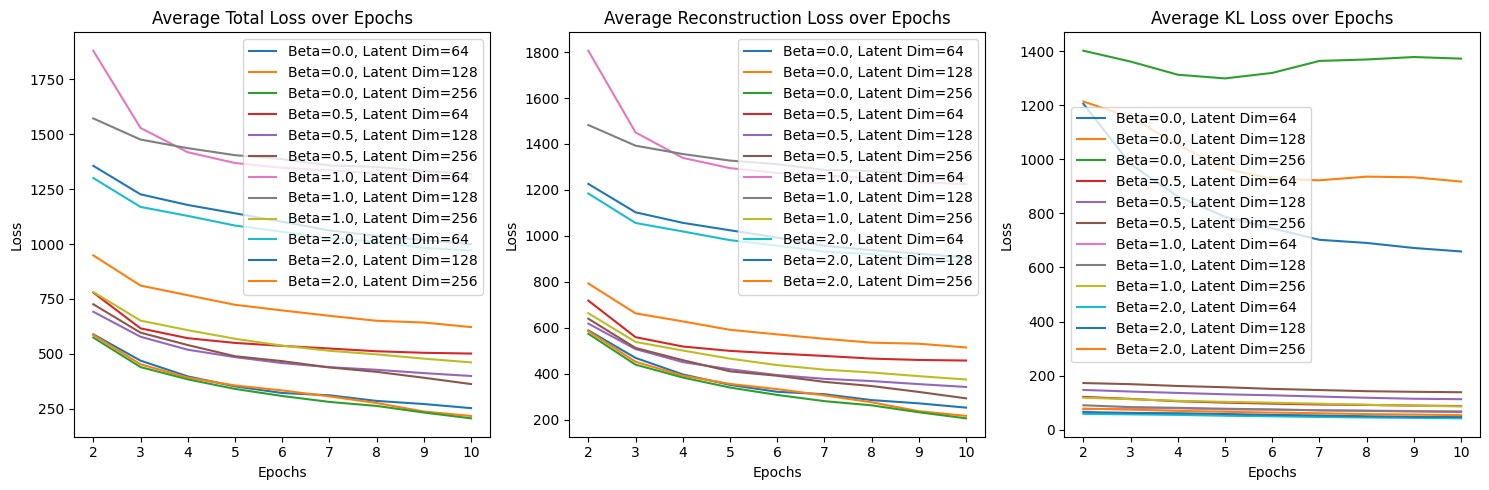

In [90]:
# Plotting results for all losses in one line
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, beta in enumerate(beta_values):
    for j, latent_dim in enumerate(latent_dim_values):
        
        axs[0].plot(range(2, epochs + 1), avg_total_loss[i, j], label=f'Beta={beta}, Latent Dim={latent_dim}')
        axs[1].plot(range(2, epochs + 1), avg_reconstruction_loss[i, j], label=f'Beta={beta}, Latent Dim={latent_dim}')
        axs[2].plot(range(2, epochs + 1), avg_kl_loss[i, j], label=f'Beta={beta}, Latent Dim={latent_dim}')

axs[0].set_title('Average Total Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Average Reconstruction Loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].set_title('Average KL Loss over Epochs')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].legend()

plt.tight_layout()
plt.show()

### Short summary

First, the optimum learning rate was chosen by running the model with beta=0.0 and latent dimension set to 128. The best reconstruction loss after 10 epochs was achieved with learning rate=0.001.

Next, grid optimization was conducted using 4 different beta values (0, 0.5, 1, 2) and 3 different values for latent space dimensions (64, 128, 256) by running 1 trial for every parameter pair and recording loss values.

Basic observation is that the lower the Beta parameter, the higher KL loss. At the extreme (beta=0.0) the KL divergence ended up being an order of magnitude greater than any of the non-zero betas. Another related general observation was that higher dimensionality of the latent space led to lower reconstruction loss, but greater KL divergence, which like before makes sense since KL loss is the regularizing term meant to keep the model "in check", not too complex.

At the end of the day, the best model was chosen by the total loss, which meant the model with the lowest beta (=0.0) and greatest latent space dimensions (=256).

In [89]:

# Choosing best beta and latent_dim by total loss
best_total_loss_idx = np.unravel_index(np.argmin(avg_total_loss), avg_total_loss.shape)
best_beta = beta_values[best_total_loss_idx[0]]
best_latent_dim = latent_dim_values[best_total_loss_idx[1]]

print(f"Best values for Total Loss - Beta: {best_beta}, Latent Dim: {best_latent_dim}")

Best values for Total Loss - Beta: 0.0, Latent Dim: 256


In [93]:
# Parameters of the best model
lr = lr #best_lr
beta = best_beta
latent_dim = best_latent_dim
epochs = 20

## Evaluation of the Best Model

Here the **Best Model** is the one with `Beta` and `Latent_dim` that gives the lowest total loss after 10 epochs.

### Image generation test

In [94]:
print(f"Model parameters: LR={lr}, Beta={beta}, Latent_dim={latent_dim}")
encoder = create_encoder(latent_dim)
decoder = create_decoder(latent_dim)
vae = VAE(encoder, decoder, beta=beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
history = vae.fit(train_data, epochs=epochs)#, verbose=0)


Model parameters: LR=0.001, Beta=0.0, Latent_dim=256
Epoch 1/20
270/270 [==============================] - 96s 342ms/step - loss: 4814.9072 - reconstruction_loss: 2260.3743 - kl_loss: 4288.8555
Epoch 2/20
270/270 [==============================] - 85s 313ms/step - loss: 588.5470 - reconstruction_loss: 548.9044 - kl_loss: 1121.6735
Epoch 3/20
270/270 [==============================] - 85s 313ms/step - loss: 449.1442 - reconstruction_loss: 430.1521 - kl_loss: 1163.1235
Epoch 4/20
270/270 [==============================] - 85s 315ms/step - loss: 382.4657 - reconstruction_loss: 366.2006 - kl_loss: 1185.0179
Epoch 5/20
270/270 [==============================] - 84s 311ms/step - loss: 342.3061 - reconstruction_loss: 336.0940 - kl_loss: 1158.3186
Epoch 6/20
270/270 [==============================] - 85s 315ms/step - loss: 316.1524 - reconstruction_loss: 305.5083 - kl_loss: 1174.8114
Epoch 7/20
270/270 [==============================] - 85s 316ms/step - loss: 285.9951 - reconstruction_loss: 27

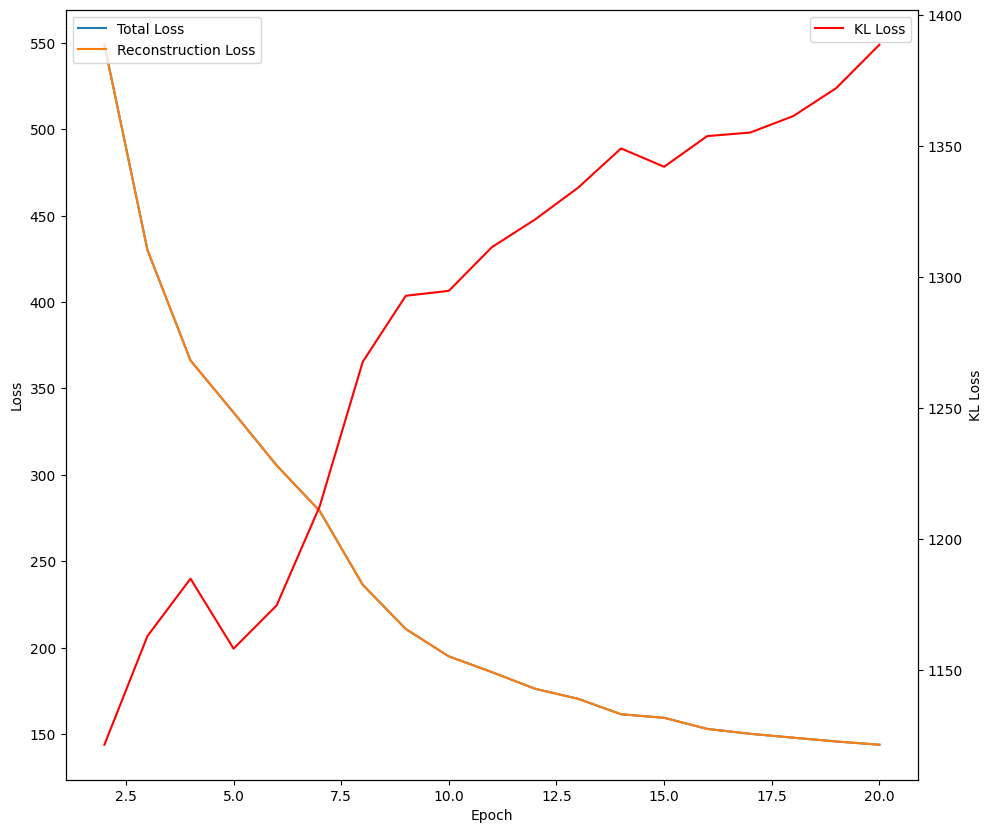

In [98]:
# Without the first epoch
xs = np.arange(2, epochs+1)
plt.plot(xs, history.history['loss'][1:], label='Total Loss')
plt.plot(xs, history.history['reconstruction_loss'][1:], label='Reconstruction Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

ax2 = plt.gca().twinx()
ax2.plot(xs, history.history['kl_loss'][1:], 'r', label='KL Loss')
ax2.set_ylabel('KL Loss')
ax2.legend(loc='upper right')

plt.show()

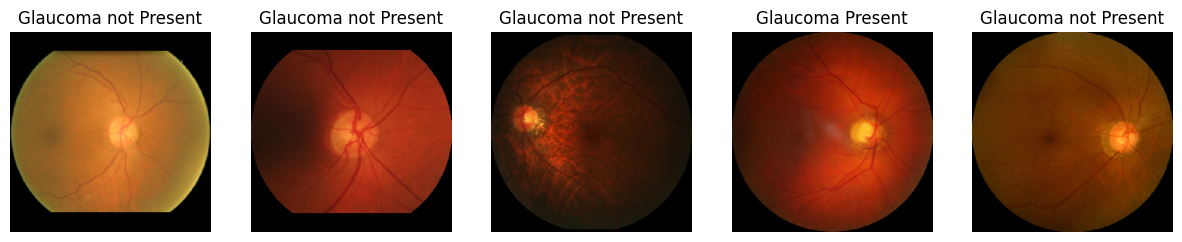

In [95]:
# Select some sample images
sample_images, sample_labels = train_data.next()

# Visualize the first 5 images in one row with labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img = array_to_img(sample_images[i])
    label = sample_labels[i].argmax()  # For one-hot encoding, get the index of the class
    axes[i].imshow(img)
    axes[i].set_title(label_map[label])
    axes[i].axis('off')

plt.show()

In [96]:
# Reconstruct selected images
z_mean, z_log_var, z = vae.encoder.predict(sample_images, verbose=0)
reconstruction = vae.decoder.predict(z)


1/1 [==============================] - 0s 132ms/step


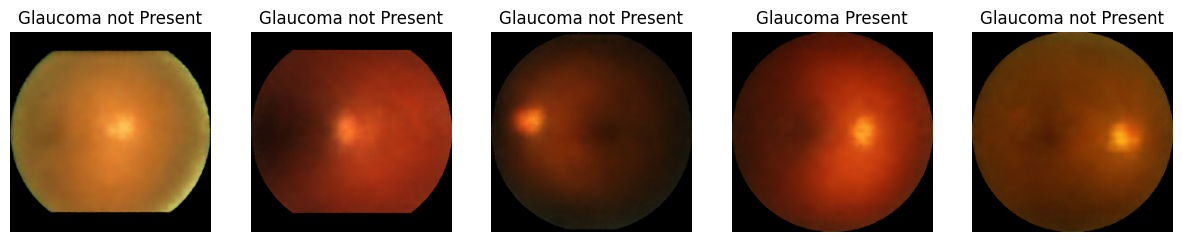

In [97]:

# Visualize the first 5 images in one row with labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img = array_to_img(reconstruction[i])
    label = sample_labels[i].argmax()  # For one-hot encoding, get the index of the class
    axes[i].imshow(img)
    axes[i].set_title(label_map[label])
    axes[i].axis('off')

plt.show()

### Short summary

A model was trained on parameters that gave the best total loss during grid optimization. The resulting images are blurry, but the main fundus features, like the optic disc, the distribution of colors or the overall round shape, are visible. The images, however are not detailed enough to display blood vessels.

### Latent space visualization

In [99]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_label_clusters(vae, data, labels, method='pca', n_components=2):
    # Get the latent representations
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)

    # Apply dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        reduced_z = reducer.fit_transform(z_mean)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components)
        reduced_z = reducer.fit_transform(z_mean)
    else:
        raise ValueError("Invalid method. Use 'pca' or 'tsne'.")

    # Plot the clusters
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(reduced_z[:, 0], reduced_z[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter, label='Class')
    plt.xlabel(f'Principal Component 1 ({method.upper()})')
    plt.ylabel(f'Principal Component 2 ({method.upper()})')
    plt.title(f'Latent Space Visualization using {method.upper()}')
    plt.show()

In [100]:
# Get all the data and labels
all_data = []
all_labels = []

# Loop through the entire dataset to extract data and labels
for i in range(len(train_data)):
    batch_data, batch_labels = train_data[i]
    all_data.append(batch_data)
    all_labels.append(np.argmax(batch_labels, axis=1))

# Concatenate the batches into a single array
all_data = np.concatenate(all_data)
all_labels = np.concatenate(all_labels)


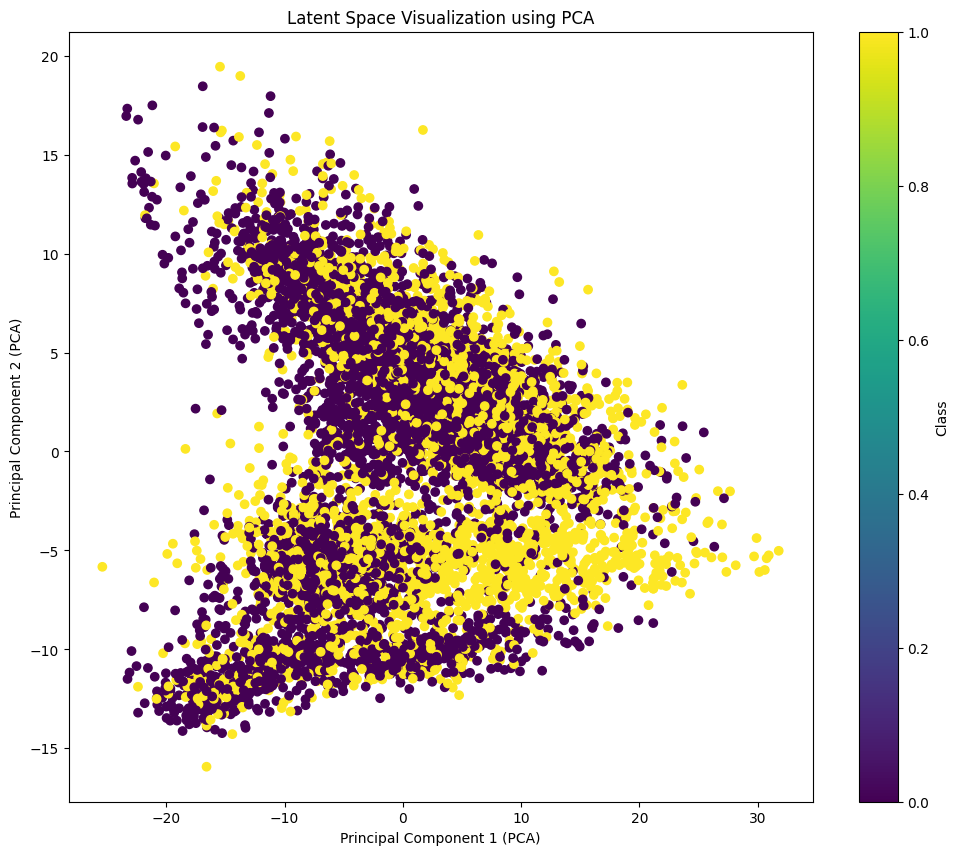

In [102]:
# PCA
plot_label_clusters(vae, all_data, all_labels, method='pca', n_components=2)

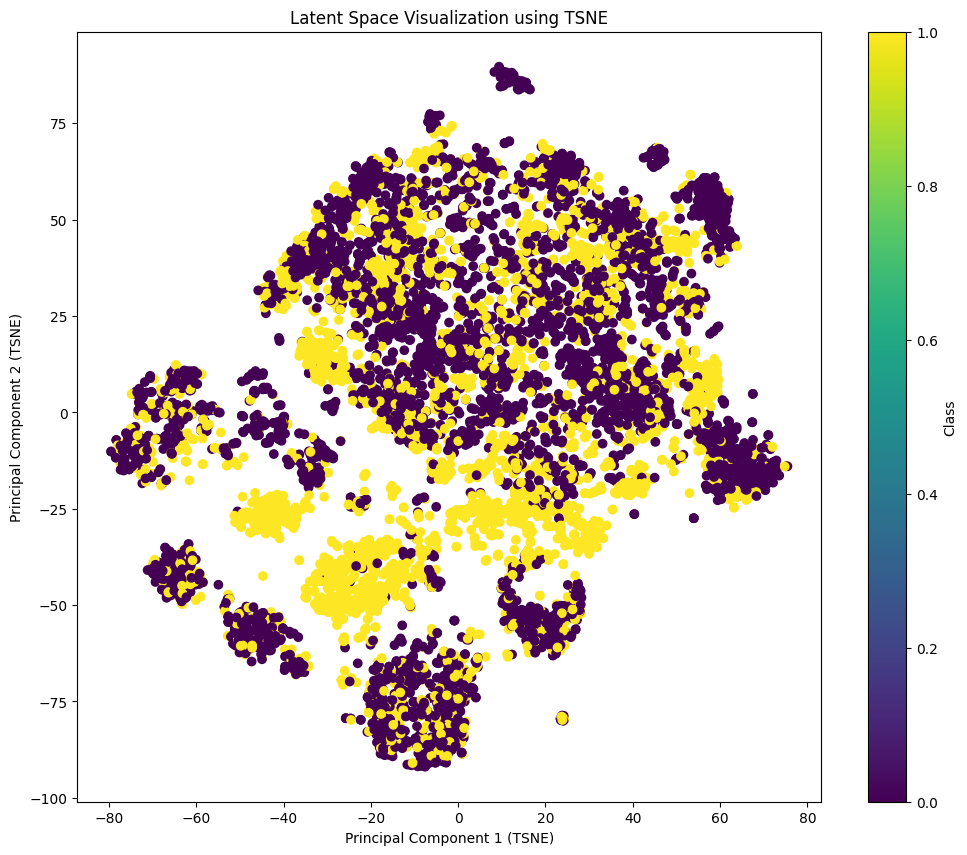

In [101]:
# t-SNE
plot_label_clusters(vae, all_data, all_labels, method='tsne', n_components=2)

eye-eye-eye...